In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import multiprocessing
from functools import partial
from PIL import Image

In [ ]:
path = '/home/ysheng/Dataset/soft_shadow/new_dataset/notsimulated_combine_male_short_outfits_genesis8_armani_casualoutfit03_Base_Pose_Standing_A/'
output_folder = os.path.join(path, 'base')

os.makedirs(output_folder, exist_ok=True)

gt_file = os.path.join(path, 'ground_truth.txt')
lines = []

with open(gt_file) as f:
    reader = csv.reader(f, delimiter=',')
    for r in reader:
        lines.append(r)

print('there are {} lines'.format(len(lines)))

In [ ]:
# construct the map
# [camera, human_rot] -> [[i, j]->[prefix]]
# oss << cur_prefix << ",";
# oss << light_pixel_pos.to_string() << ",";
# oss << to_string(manager.cur_camera->_position) << ",";
# oss << target_rot << ",";
# oss << to_string(render_target->compute_world_center()) << ",";
# oss << to_string(manager.m_lights[0]->m_verts[0]) << std::endl;
# gt_str.push_back(oss.str());
group_data = {}
for l in tqdm(lines):
    prefix = l[0]
    ibl = (int(l[1]), int(l[2]))
    camera_pos = (l[3], l[4], l[5])
    rot = l[6]
    target_center = (l[7], l[8], l[9])
    light_pos = (l[10], l[11], l[12])

    key = (camera_pos, rot)
    if key not in group_data.keys():
        group_data[key] = dict()

    ibl_key = ibl
    group_data[key][ibl_key] = prefix

In [ ]:
print('keys: ',len(group_data.keys()))
print('keys: ', group_data.keys())

# h x w x x x y 
h, w, x, y = 256,256, 512, 256-176 

print(h * w * x * y * 4 / 1024 / 1024 /1024)

all_data = np.zeros((h, w, x, y))

In [ ]:
info_str = ""
new_prefix = 0
img_folder = os.path.join(path, 'imgs')
x_begin, y_begin = 0, 176

meta_str, new_base_prefix = "", 0

for key_id, key in enumerate(group_data.keys()):
    # loading data
    for (ibl, prefix) in tqdm(group_data[key].items()):
        x, y = ibl
        if y < 176:
            continue
        
        if y > 255:
            print('y: {} is out of range, bug here'.format(y))
            break
        
        shadow_path = os.path.join(img_folder, prefix + '_shadow.png')
        shadow_np = plt.imread(shadow_path)
        
        cur_x, cur_y = x - x_begin, y - y_begin
        all_data[:,:, cur_x, cur_y] = shadow_np[:,:,0]
    
    # saving new dataset
    print('prepare bases')
    x_range, y_range = 8, 8
    x_iter, y_iter = 512//x_range, (256-y_begin)//y_range

    for xi in tqdm(range(x_iter)):
        for yi in range(y_iter):
            x_pos, y_pos = xi * 16, yi * 16
            new_ibl = np.sum(all_data[:,:,x_pos:x_pos + x_range, y_pos:y_pos+y_range], axis=(2,3))

            meta_str += '{},{},{},{} \n'.format(key_id, new_base_prefix,xi, yi)
            np.save(os.path.join(output_folder, '{:08d}.npy'.format(new_base_prefix)),new_ibl)
            new_base_prefix += 1

# save meta data
with open(os.path.join(output_folder, 'metadata.csv'), 'w+') as wf:
    wf.write(meta_str)

print('finsihed')

In [ ]:
# saving new dataset
print('prepare bases')
new_base_prefix = 0
x_range, y_range = 8, 8
x_iter, y_iter = 512//x_range, (256-y_begin)//y_range

for xi in tqdm(range(x_iter)):
    for yi in range(y_iter):
        x_pos, y_pos = xi * x_range, yi * y_range
        new_ibl = np.sum(all_data[:,:,x_pos:x_pos + x_range, y_pos:y_pos+y_range], axis=(2,3))

        meta_str += '{},{},{},{} \n'.format(key_id, new_base_prefix,xi, yi)
        np.save(os.path.join(output_folder, '{:08d}.npy'.format(new_base_prefix)),new_ibl)
        new_base_prefix += 1

In [ ]:
test_np = np.load(os.path.join(output_folder, '00000000.npy')) 

plt.figure()
plt.imshow(test_np, cmap='gray')
plt.show()

In [56]:
import numbergen as ng
import imagen as ig

gs = ig.Composite(operator=np.add,
                  generators=[ig.Gaussian(size=0.15,
                                          x=ng.UniformRandom(seed=i+1)-0.5,
                                          y=ng.UniformRandom(seed=i+2)-0.5,
                                          orientation=np.pi*ng.UniformRandom(seed=i+3))
                                for i in range(10)])
NdLayout(gs.anim(4)).cols(5)
print(gs().shape)
print(np.max(gs()))

(256, 256)
2.501708063171075


In [49]:
path = '/home/ysheng/Dataset/soft_shadow/new_dataset/notsimulated_combine_male_short_outfits_genesis8_armani_casualoutfit03_Base_Pose_Standing_A/'
output_folder = os.path.join(path, 'base')

test_np = np.load(os.path.join(output_folder, '000_shadow.npy')) 
print(test_np.shape)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
(256, 256, 64, 10)


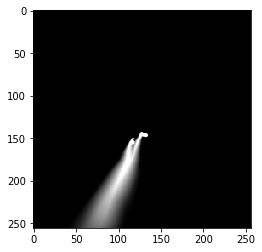

In [48]:
plt.figure()
plt.imshow(test_np[:,:,1,0], cmap='gray')
plt.show()

In [53]:
256 * 256 * 64 * 10 / 1024 / 1024/ 1024

40.0

In [58]:
test_np = np.ones((25,25,64,10))
pattern = np.random.rand(10, 64)

In [62]:
result = np.tensordot(test_np, pattern, axes=([2,3],[1,0]))
print(result.shape)
print(test_np)

(25, 25)
[[[[1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. ... 1. 1. 1.]
   ...
   [1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. ... 1. 1. 1.]]

  [[1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. ... 1. 1. 1.]
   ...
   [1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. ... 1. 1. 1.]]

  [[1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. ... 1. 1. 1.]
   ...
   [1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. ... 1. 1. 1.]]

  ...

  [[1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. ... 1. 1. 1.]
   ...
   [1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. ... 1. 1. 1.]]

  [[1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. ... 1. 1. 1.]
   ...
   [1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. ... 1. 1. 1.]]

  [[1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. ... 1. 1. 1.]
   ...
   [1. 1. 1. ... 1. 1. 1.]
   [1. 1. 1. .